Cell 1 — Imports & Config

In [ ]:
# Install required packages
!pip install holidays optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
plt.style.use("seaborn-v0_8")

print("=======All packages loaded successfully===========")

=======All packages loaded successfully===========


Cell 2 — Load data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total records: 2017
Date range: 2020-01-01 00:00:00 to 2025-07-11 00:00:00
Price range: Rs 53.00 - Rs 1950.00

Price Statistics:
count    2017.000000
mean      236.795537
std       177.849380
min        53.000000
25%       125.000000
50%       175.000000
75%       305.000000
max      1950.000000
Name: carrot_price, dtype: float64


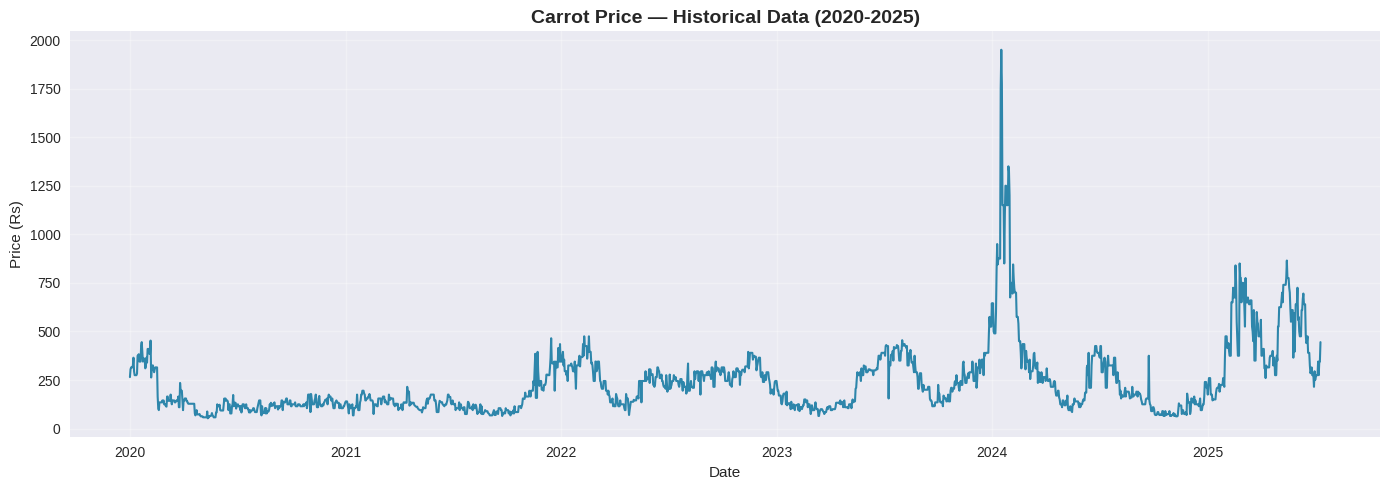

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

csv_file_path = "/content/drive/MyDrive/RESEARCH-ALL-in-one/ALL-Data-in-one-CSV/best-dataset/dambulla_market_dataset.csv"
df = pd.read_csv(csv_file_path, parse_dates=["date"])
df = df.sort_values("date")
df.set_index("date", inplace=True)

# Extract carrot price series
ts = df["carrot_price"].dropna()
print(f"Total records: {len(ts)}")
print(f"Date range: {ts.index.min()} to {ts.index.max()}")
print(f"Price range: Rs {ts.min():.2f} - Rs {ts.max():.2f}")

# Basic statistics
print("\nPrice Statistics:")
print(ts.describe())

# Visualize
plt.figure(figsize=(14,5))
plt.plot(ts, linewidth=1.5, color='#2E86AB')
plt.title("Carrot Price — Historical Data (2020-2025)", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Price (Rs)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Cell 3 — Feature Engineering for Univariate

In [ ]:
# Add temporal features and rolling statistics
df_features = pd.DataFrame(index=ts.index)
df_features['price'] = ts.values

# Rolling statistics (capture trends)
df_features['rolling_mean_7'] = ts.rolling(window=7, min_periods=1).mean()
df_features['rolling_std_7'] = ts.rolling(window=7, min_periods=1).std().fillna(0)
df_features['rolling_mean_14'] = ts.rolling(window=14, min_periods=1).mean()
df_features['rolling_mean_30'] = ts.rolling(window=30, min_periods=1).mean()

# Lag features
df_features['lag_1'] = ts.shift(1).fillna(method='bfill')
df_features['lag_7'] = ts.shift(7).fillna(method='bfill')

# Price change momentum
df_features['price_change'] = ts.diff().fillna(0)
df_features['price_change_pct'] = ts.pct_change().fillna(0)

# Temporal features
df_features['day_of_week'] = df_features.index.dayofweek
df_features['day_of_month'] = df_features.index.day
df_features['month'] = df_features.index.month
df_features['quarter'] = df_features.index.quarter

# Drop any remaining NaN
df_features = df_features.fillna(method='bfill').fillna(method='ffill')

print("Feature engineering completed")
print(f"Features shape: {df_features.shape}")
print("\nFeatures created:")
print(df_features.columns.tolist())

Feature engineering completed
Features shape: (2017, 13)

Features created:
['price', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_mean_30', 'lag_1', 'lag_7', 'price_change', 'price_change_pct', 'day_of_week', 'day_of_month', 'month', 'quarter']


Cell 4 — Improved Scaling & Sequence Creation

In [ ]:
# Use RobustScaler (better for outliers than MinMaxScaler)
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df_features.values)

def create_sequences_multifeature(data, target_col_idx, n_steps):
    """
    Create sequences for multifeature time series
    target_col_idx: index of the column we want to predict (price = 0)
    """
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])  # All features
        y.append(data[i, target_col_idx])  # Only price
    return np.array(X), np.array(y)

# Experiment with different sequence lengths
n_steps = 30  # Increased from 20 to 30 (capturing monthly patterns)
target_col_idx = 0  # Price is first column

X, y = create_sequences_multifeature(features_scaled, target_col_idx, n_steps)

print(f"Sequences created")
print(f"X shape: {X.shape}")  # (samples, timesteps, features)
print(f"y shape: {y.shape}")  # (samples,)

Sequences created
X shape: (1987, 30, 13)
y shape: (1987,)


Cell 5 — Better Train/Val/Test Split

In [ ]:
# 70% train, 15% validation, 15% test (more realistic)
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print("=======Dataset Split ===========")
print(f"  Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

=======Dataset Split ===========
  Train: 1390 samples (70.0%)
  Val:   298 samples (15.0%)
  Test:  299 samples (15.0%)


Cell 6 — Enhanced LSTM Architecture


In [ ]:
from tensorflow.keras import regularizers

# Clear any previous models
import tensorflow as tf
tf.keras.backend.clear_session()

# Build improved model
model = Sequential([
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True,
                       kernel_regularizer=regularizers.l2(0.001)),
                  input_shape=(n_steps, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                       kernel_regularizer=regularizers.l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),

    # Third LSTM layer
    LSTM(32, activation='tanh', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    # Dense layers
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile with optimized settings
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,633 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 832 (3.25 KB)

Cell 7 — Training with Advanced Callbacks

In [ ]:
# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '/content/best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print("==========Training completed!============")

Starting training...
Epoch 1/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7825 - mae: 0.5399
Epoch 1: val_loss improved from inf to 1.17124, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.7763 - mae: 0.5318 - val_loss: 1.1712 - val_mae: 0.9624 - learning_rate: 0.0010
Epoch 2/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5799 - mae: 0.3021
Epoch 2: val_loss improved from 1.17124 to 1.08448, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5790 - mae: 0.3016 - val_loss: 1.0845 - val_mae: 0.9441 - learning_rate: 0.0010
Epoch 3/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4936 - mae: 0.2484
Epoch 3: val_loss improved from 1.08448 to 0.96364, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.4929 - mae: 0.2482 - val_loss: 0.9636 - val_mae: 0.8675 - learning_rate: 0.0010
Epoch 4/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4241 - mae: 0.2254
Epoch 4: val_loss improved from 0.96364 to 0.90396, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4232 - mae: 0.2254 - val_loss: 0.9040 - val_mae: 0.8542 - learning_rate: 0.0010
Epoch 5/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3619 - mae: 0.2172
Epoch 5: val_loss improved from 0.90396 to 0.85479, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3614 - mae: 0.2173 - val_loss: 0.8548 - val_mae: 0.8626 - learning_rate: 0.0010
Epoch 6/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3107 - mae: 0.2064
Epoch 6: val_loss improved from 0.85479 to 0.78056, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3102 - mae: 0.2063 - val_loss: 0.7806 - val_mae: 0.8220 - learning_rate: 0.0010
Epoch 7/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2624 - mae: 0.1928
Epoch 7: val_loss improved from 0.78056 to 0.69043, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2620 - mae: 0.1929 - val_loss: 0.6904 - val_mae: 0.7492 - learning_rate: 0.0010
Epoch 8/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2239 - mae: 0.1837
Epoch 8: val_loss improved from 0.69043 to 0.63046, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2236 - mae: 0.1837 - val_loss: 0.6305 - val_mae: 0.6914 - learning_rate: 0.0010
Epoch 9/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1995 - mae: 0.1888
Epoch 9: val_loss improved from 0.63046 to 0.56102, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1992 - mae: 0.1888 - val_loss: 0.5610 - val_mae: 0.6329 - learning_rate: 0.0010
Epoch 10/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1718 - mae: 0.1848
Epoch 10: val_loss did not improve from 0.56102
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1716 - mae: 0.1849 - val_loss: 0.5896 - val_mae: 0.7221 - learning_rate: 0.0010
Epoch 11/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1516 - mae: 0.1860
Epoch 11: val_loss improved from 0.56102 to 0.53763, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1512 - mae: 0.1855 - val_loss: 0.5376 - val_mae: 0.6683 - learning_rate: 0.0010
Epoch 12/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1337 - mae: 0.1834
Epoch 12: val_loss improved from 0.53763 to 0.52925, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1333 - mae: 0.1825 - val_loss: 0.5292 - val_mae: 0.6837 - learning_rate: 0.0010
Epoch 13/150
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1149 - mae: 0.1688
Epoch 13: val_loss improved from 0.52925 to 0.50798, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1149 - mae: 0.1689 - val_loss: 0.5080 - val_mae: 0.6541 - learning_rate: 0.0010
Epoch 14/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1049 - mae: 0.1715
Epoch 14: val_loss improved from 0.50798 to 0.47472, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1047 - mae: 0.1714 - val_loss: 0.4747 - val_mae: 0.6160 - learning_rate: 0.0010
Epoch 15/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0924 - mae: 0.1660
Epoch 15: val_loss improved from 0.47472 to 0.47326, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0924 - mae: 0.1665 - val_loss: 0.4733 - val_mae: 0.6258 - learning_rate: 0.0010
Epoch 16/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0857 - mae: 0.1739
Epoch 16: val_loss improved from 0.47326 to 0.46400, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0855 - mae: 0.1735 - val_loss: 0.4640 - val_mae: 0.6317 - learning_rate: 0.0010
Epoch 17/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0754 - mae: 0.1594
Epoch 17: val_loss did not improve from 0.46400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0754 - mae: 0.1599 - val_loss: 0.4672 - val_mae: 0.6493 - learning_rate: 0.0010
Epoch 18/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0698 - mae: 0.1567
Epoch 18: val_loss improved from 0.46400 to 0.44828, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0697 - mae: 0.1566 - val_loss: 0.4483 - val_mae: 0.6170 - learning_rate: 0.0010
Epoch 19/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0642 - mae: 0.1566
Epoch 19: val_loss did not improve from 0.44828
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0642 - mae: 0.1567 - val_loss: 0.4842 - val_mae: 0.6872 - learning_rate: 0.0010
Epoch 20/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0573 - mae: 0.1482
Epoch 20: val_loss did not improve from 0.44828
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0573 - mae: 0.1482 - val_loss: 0.4520 - val_mae: 0.6444 - learning_rate: 0.0010
Epoch 21/150
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0540 - mae: 0.1495
Epoch 21: val_loss did not improve from 0.44828
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0539 - mae: 0.1495 - val_loss: 0.4743 - val_mae: 0.6893 - learning_rate: 0.0010
Epoch 22/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0531 - mae: 0.1597
Epoch 22

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0530 - mae: 0.1595 - val_loss: 0.4388 - val_mae: 0.6440 - learning_rate: 0.0010
Epoch 23/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0485 - mae: 0.1578
Epoch 23: val_loss did not improve from 0.43882
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0486 - mae: 0.1580 - val_loss: 0.4729 - val_mae: 0.6953 - learning_rate: 0.0010
Epoch 24/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0484 - mae: 0.1583
Epoch 24: val_loss did not improve from 0.43882
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0482 - mae: 0.1579 - val_loss: 0.4666 - val_mae: 0.6753 - learning_rate: 0.0010
Epoch 25/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0464 - mae: 0.1592
Epoch 25: val_loss improved from 0.43882 to 0.40767, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0462 - mae: 0.1586 - val_loss: 0.4077 - val_mae: 0.6053 - learning_rate: 0.0010
Epoch 26/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0389 - mae: 0.1449
Epoch 26: val_loss did not improve from 0.40767
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0389 - mae: 0.1450 - val_loss: 0.4446 - val_mae: 0.6674 - learning_rate: 0.0010
Epoch 27/150
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0392 - mae: 0.1515
Epoch 27: val_loss did not improve from 0.40767
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0392 - mae: 0.1515 - val_loss: 0.4092 - val_mae: 0.6078 - learning_rate: 0.0010
Epoch 28/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0392 - mae: 0.1605
Epoch 28: val_loss improved from 0.40767 to 0.39649, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0392 - mae: 0.1602 - val_loss: 0.3965 - val_mae: 0.5889 - learning_rate: 0.0010
Epoch 29/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0355 - mae: 0.1503
Epoch 29: val_loss did not improve from 0.39649
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0356 - mae: 0.1504 - val_loss: 0.3999 - val_mae: 0.5915 - learning_rate: 0.0010
Epoch 30/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0348 - mae: 0.1493
Epoch 30: val_loss did not improve from 0.39649
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0349 - mae: 0.1496 - val_loss: 0.4326 - val_mae: 0.6550 - learning_rate: 0.0010
Epoch 31/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0356 - mae: 0.1559
Epoch 31: val_loss did not improve from 0.39649
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0356 - mae: 0.1559 - val_loss: 0.4431 - val_mae: 0.6681 - learning_rate: 0.0010
Epoch 32/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0291 - mae: 0.1392
Epoch 32

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0349 - mae: 0.1550 - val_loss: 0.3844 - val_mae: 0.5727 - learning_rate: 0.0010
Epoch 34/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0294 - mae: 0.1435
Epoch 34: val_loss did not improve from 0.38440
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0294 - mae: 0.1434 - val_loss: 0.4085 - val_mae: 0.6095 - learning_rate: 0.0010
Epoch 35/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0300 - mae: 0.1502
Epoch 35: val_loss did not improve from 0.38440
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0300 - mae: 0.1503 - val_loss: 0.3931 - val_mae: 0.6084 - learning_rate: 0.0010
Epoch 36/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0300 - mae: 0.1509
Epoch 36: val_loss did not improve from 0.38440
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0300 - mae: 0.1508 - val_loss: 0.4000 - val_mae: 0.6101 - learning_rate: 0.0010
Epoch 37/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0290 - mae: 0.1480
Epoch 37

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0289 - mae: 0.1478 - val_loss: 0.3832 - val_mae: 0.5710 - learning_rate: 0.0010
Epoch 38/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0276 - mae: 0.1411
Epoch 38: val_loss did not improve from 0.38316
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0276 - mae: 0.1413 - val_loss: 0.4422 - val_mae: 0.6666 - learning_rate: 0.0010
Epoch 39/150
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0261 - mae: 0.1368
Epoch 39: val_loss did not improve from 0.38316
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0262 - mae: 0.1375 - val_loss: 0.4400 - val_mae: 0.6701 - learning_rate: 0.0010
Epoch 40/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0279 - mae: 0.1443
Epoch 40: val_loss did not improve from 0.38316
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0279 - mae: 0.1443 - val_loss: 0.4085 - val_mae: 0.6097 - learning_rate: 0.0010
Epoch 41/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0273 - mae: 0.1452
Epoch 41

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0273 - mae: 0.1452 - val_loss: 0.3803 - val_mae: 0.5754 - learning_rate: 0.0010
Epoch 42/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0274 - mae: 0.1428
Epoch 42: val_loss did not improve from 0.38031
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0273 - mae: 0.1427 - val_loss: 0.3911 - val_mae: 0.6021 - learning_rate: 0.0010
Epoch 43/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0253 - mae: 0.1415
Epoch 43: val_loss improved from 0.38031 to 0.37544, saving model to /content/best_lstm_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0253 - mae: 0.1415 - val_loss: 0.3754 - val_mae: 0.5841 - learning_rate: 0.0010
Epoch 44/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0282 - mae: 0.1478
Epoch 44: val_loss did not improve from 0.37544
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0282 - mae: 0.1477 - val_loss: 0.3904 - val_mae: 0.5845 - learning_rate: 0.0010
Epoch 45/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0245 - mae: 0.1380
Epoch 45: val_loss did not improve from 0.37544
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0245 - mae: 0.1382 - val_loss: 0.4338 - val_mae: 0.6608 - learning_rate: 0.0010
Epoch 46/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0242 - mae: 0.1382
Epoch 46: val_loss did not improve from 0.37544
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0243 - mae: 0.1385 - val_loss: 0.4083 - val_mae: 0.6043 - learning_rate: 0.0010
Epoch 47/150
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0247 - mae: 0.1393
Epoch 47

Cell 8 — Training Visualization



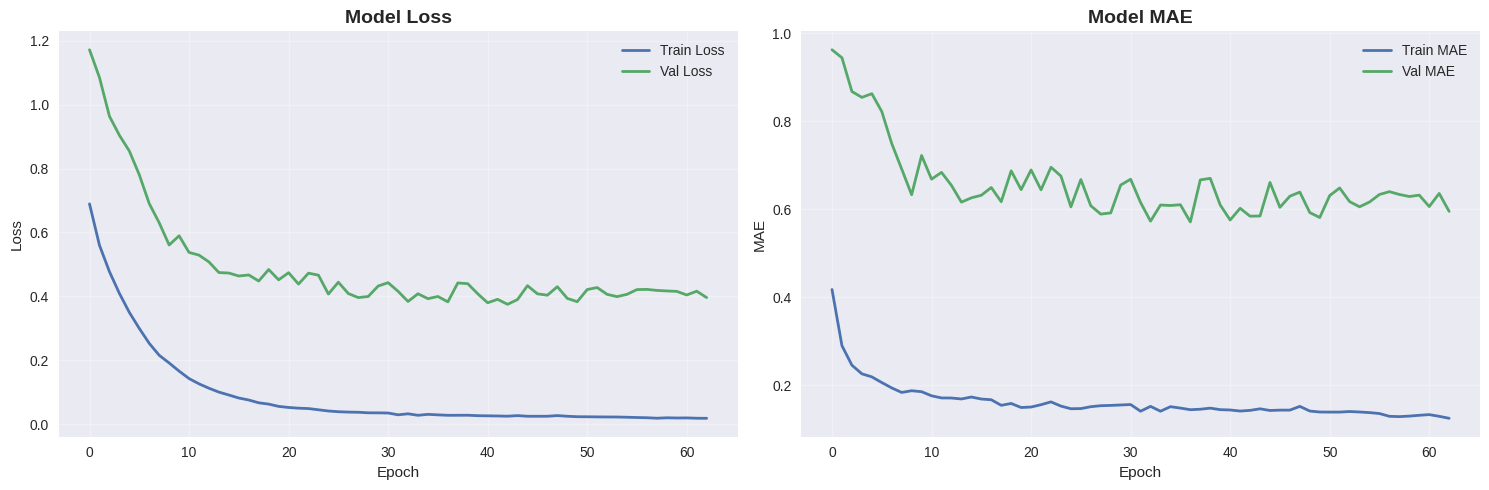

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Cell 9 — Predictions & Inverse Transform

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

# Inverse transform (back to original scale)
# Create dummy arrays with same shape as df_features for inverse transform
def inverse_transform_price(scaled_values):
    dummy = np.zeros((len(scaled_values), df_features.shape[1]))
    dummy[:, 0] = scaled_values.flatten()  # Price is column 0
    inversed = scaler.inverse_transform(dummy)
    return inversed[:, 0]

y_train_actual = inverse_transform_price(y_train)
y_train_pred_inv = inverse_transform_price(y_train_pred)

y_val_actual = inverse_transform_price(y_val)
y_val_pred_inv = inverse_transform_price(y_val_pred)

y_test_actual = inverse_transform_price(y_test)
y_test_pred_inv = inverse_transform_price(y_test_pred)

print("===========Inverse transformation completed================")

===========Inverse transformation completed================


Cell 10 — Comprehensive Metrics

In [ ]:
def calculate_metrics(actual, predicted, dataset_name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    accuracy = 100 - mape  # Simple accuracy based on MAPE

    print(f"\n{'='*50}")
    print(f" {dataset_name} METRICS")
    print(f"{'='*50}")
    print(f"RMSE:     {rmse:.2f} Rs")
    print(f"MAE:      {mae:.2f} Rs")
    print(f"MAPE:     {mape:.2f}%")
    print(f"R²:       {r2:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Interpretation
    if mape < 10:
        print("===Excellent forecasting accuracy====")
    elif mape < 20:
        print("===== Good forecasting accuracy============")
    elif mape < 50:
        print("=========== Reasonable forecasting accuracy==========")
    else:
        print("=========== Poor forecasting accuracy==========")

    return rmse, mae, mape, r2, accuracy

# Calculate for all sets
train_metrics = calculate_metrics(y_train_actual, y_train_pred_inv, "TRAIN SET")
val_metrics = calculate_metrics(y_val_actual, y_val_pred_inv, "VALIDATION SET")
test_metrics = calculate_metrics(y_test_actual, y_test_pred_inv, "TEST SET")

# Store test metrics for later use
test_mae = test_metrics[1]
test_mape = test_metrics[2]


 TRAIN SET METRICS
RMSE:     33.68 Rs
MAE:      23.76 Rs
MAPE:     14.09%
R²:       0.8746
Accuracy: 85.91%
===== Good forecasting accuracy============

 VALIDATION SET METRICS
RMSE:     236.80 Rs
MAE:      105.14 Rs
MAPE:     20.19%
R²:       0.3151
Accuracy: 79.81%
=========== Reasonable forecasting accuracy==========

 TEST SET METRICS
RMSE:     136.82 Rs
MAE:      87.95 Rs
MAPE:     21.90%
R²:       0.6428
Accuracy: 78.10%
=========== Reasonable forecasting accuracy==========


Cell 11 — Visualization of Results

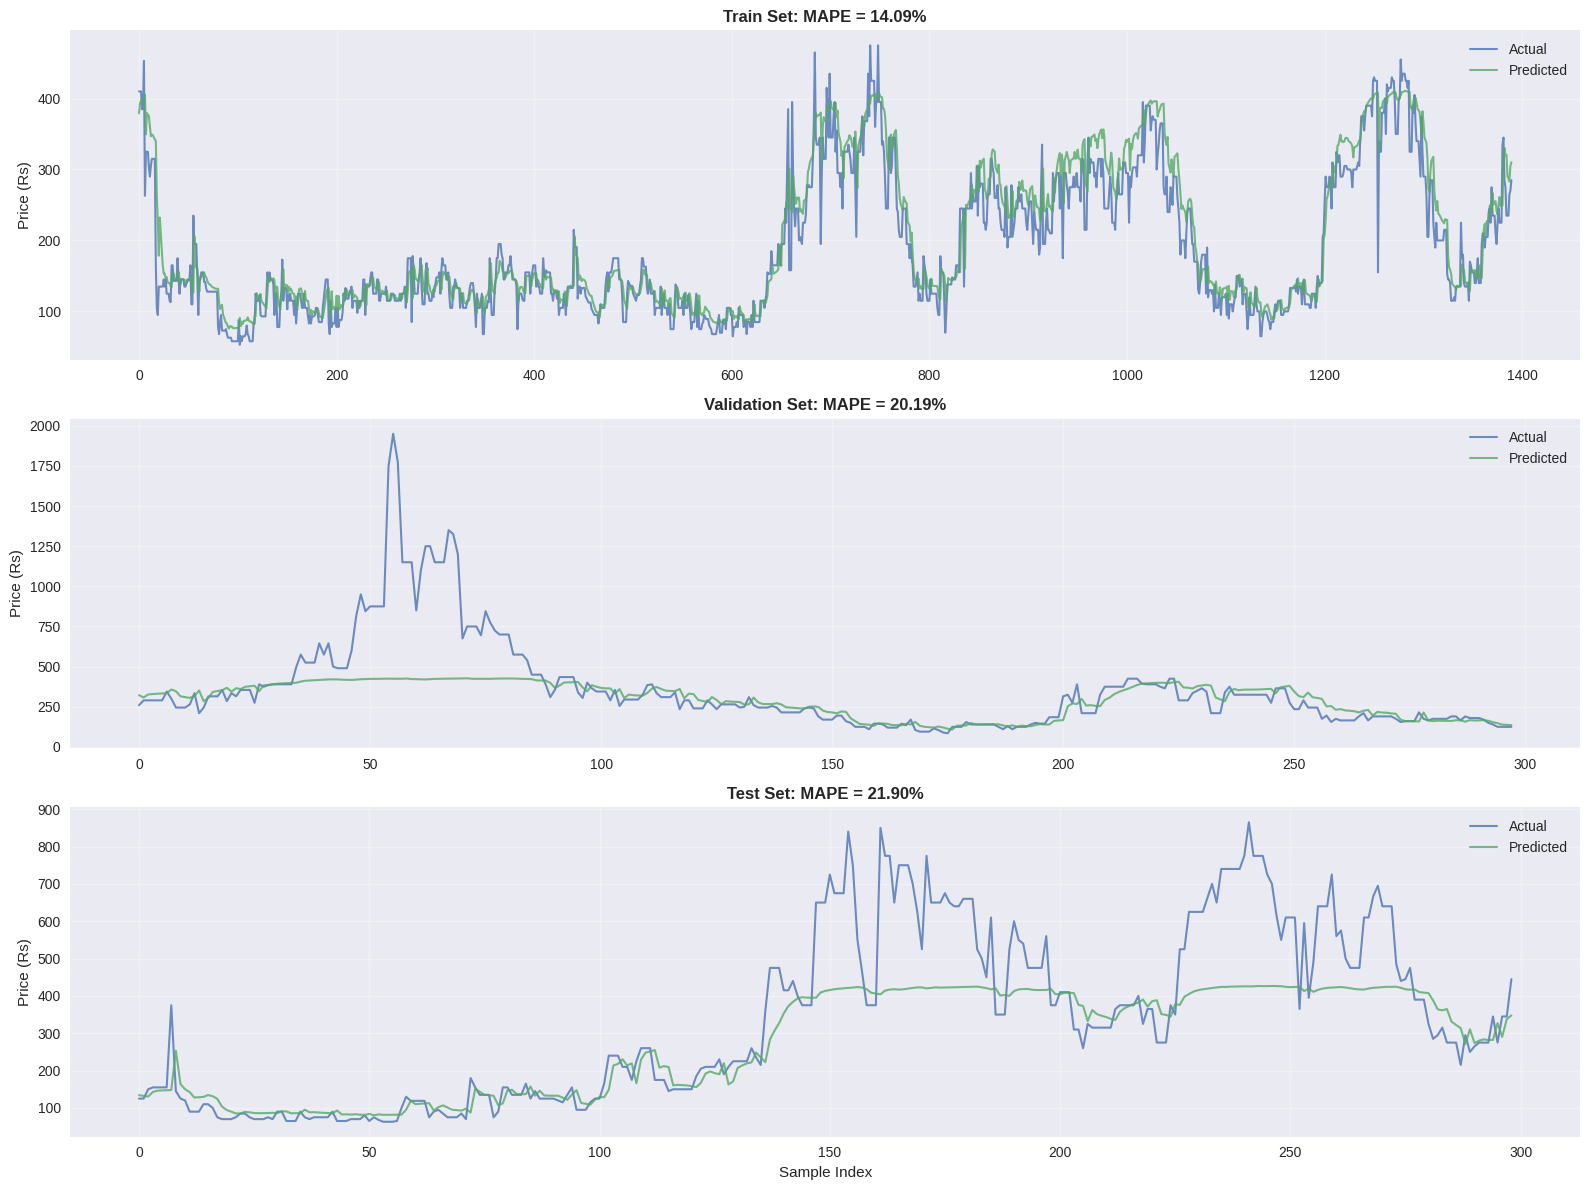

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Train
axes[0].plot(y_train_actual, label='Actual', linewidth=1.5, alpha=0.8)
axes[0].plot(y_train_pred_inv, label='Predicted', linewidth=1.5, alpha=0.8)
axes[0].set_title(f'Train Set: MAPE = {train_metrics[2]:.2f}%', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (Rs)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation
axes[1].plot(y_val_actual, label='Actual', linewidth=1.5, alpha=0.8)
axes[1].plot(y_val_pred_inv, label='Predicted', linewidth=1.5, alpha=0.8)
axes[1].set_title(f'Validation Set: MAPE = {val_metrics[2]:.2f}%', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price (Rs)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Test
axes[2].plot(y_test_actual, label='Actual', linewidth=1.5, alpha=0.8)
axes[2].plot(y_test_pred_inv, label='Predicted', linewidth=1.5, alpha=0.8)
axes[2].set_title(f'Test Set: MAPE = {test_metrics[2]:.2f}%', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Price (Rs)')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Cell 12 — Save Predictions for AI Agent

In [ ]:
# Get the actual dates for test set
test_start_idx = train_size + val_size + n_steps
test_dates = df_features.index[test_start_idx:test_start_idx + len(y_test)]

# Create comprehensive prediction dataframe
df_pred = pd.DataFrame({
    "date": test_dates,
    "actual_price": y_test_actual,
    "predicted_price": y_test_pred_inv,
    "error": y_test_actual - y_test_pred_inv,
    "error_pct": ((y_test_actual - y_test_pred_inv) / y_test_actual) * 100
})

# Save to CSV
out_path = "/content/drive/MyDrive/RESEARCH-ALL-in-one/ALL-Data-in-one-CSV/Univariate-LSTM_&_AI_Agent/dambulla_market_predicted_improved.csv"
df_pred.to_csv(out_path, index=False)

print(f"====== Predictions saved to: {out_path}")
print(f"\n====Preview:=====")
print(df_pred.head(10))
print(f"\n====Summary:=====")
print(df_pred.describe())

====== Predictions saved to: /content/drive/MyDrive/RESEARCH-ALL-in-one/ALL-Data-in-one-CSV/Univariate-LSTM_&_AI_Agent/dambulla_market_predicted_improved.csv

====Preview:=====
        date  actual_price  predicted_price       error  error_pct
0 2024-09-16         125.0       134.169604   -9.169604  -7.335683
1 2024-09-17         125.0       132.174751   -7.174751  -5.739801
2 2024-09-18         150.0       130.596073   19.403927  12.935952
3 2024-09-19         155.0       142.825457   12.174543   7.854544
4 2024-09-20         155.0       146.276004    8.723996   5.628385
5 2024-09-21         155.0       146.896653    8.103347   5.227966
6 2024-09-22         155.0       147.359158    7.640842   4.929576
7 2024-09-23         375.0       147.941706  227.058294  60.548878
8 2024-09-24         145.0       253.338099 -108.338099 -74.715930
9 2024-09-25         125.0       163.822816  -38.822816 -31.058253

====Summary:=====
                      date  actual_price  predicted_price       err

PART B: IMPROVED AI AGENT WITH QWEN 7B

Cell 13 — Install RAG Packages

In [ ]:
!pip install -q langchain faiss-cpu chromadb sentence-transformers tiktoken transformers accelerate bitsandbytes holidays
print("==== All packages installed====")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.4 MB/s eta 0:00:00
==== All packages installed====


Cell 14 — Load Qwen 7B with 4-bit Quantization

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

print("Loading Qwen 7B with 4-bit quantization...")
print("This will take 5-10 minutes on first run (downloading ~4GB)")

model_id = "Qwen/Qwen2.5-7B-Instruct"

# 4-bit quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True
)

# Load model
model_llm = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

print("=====Qwen 7B loaded successfully=====")
print(f"=====VRAM usage: ~4-5GB========")

# Test generation
def generate_response(prompt, max_new_tokens=512, temperature=0.3):
    messages = [{"role": "user", "content": prompt}]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer([text], return_tensors="pt").to(model_llm.device)

    outputs = model_llm.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=True,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(outputs[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
    return response.strip()

# Quick test
test_response = generate_response("Hello! Can you help me with price predictions?")
print(f"\n🧪 Test response: {test_response}")

Loading Qwen 7B with 4-bit quantization...
This will take 5-10 minutes on first run (downloading ~4GB)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

=====Qwen 7B loaded successfully=====
=====VRAM usage: ~4-5GB========

🧪 Test response: Of course! I can help you with price predictions using various methods depending on the context and data available to you. Here are some common approaches:

1. **Historical Data Analysis**: If you have historical sales data, you can use statistical methods like time series analysis (e.g., ARIMA) or machine learning models (like LSTM for time series forecasting).

2. **Regression Models**: Linear regression, logistic regression, or more complex models like Random Forest or Gradient Boosting can be used if you have relevant features that influence the price.

3. **Machine Learning Models**: Advanced techniques such as neural networks, especially those designed for time series prediction, can be very effective.

4. **Economic Indicators**: Incorporating macroeconomic indicators (like GDP growth, inflation rates) into your model can improve accuracy.

5. **Market Sentiment Analysis**: Using natural lang

Cell 15 — Load Prediction Data & Prepare

In [ ]:
import pandas as pd
import holidays

# Load predictions
pred_csv = "/content/drive/MyDrive/RESEARCH-ALL-in-one/ALL-Data-in-one-CSV/Univariate-LSTM_&_AI_Agent/dambulla_market_predicted_improved.csv"
df_pred = pd.read_csv(pred_csv, parse_dates=["date"])
df_pred["date"] = pd.to_datetime(df_pred["date"]).dt.normalize()
df_pred = df_pred.sort_values("date").reset_index(drop=True)

print(f"====== Loaded {len(df_pred)} prediction records==========")
print(f"======Date range: {df_pred['date'].min()} to {df_pred['date'].max()}====")

# Initialize Sri Lanka holidays
lk_holidays = holidays.SriLanka()

# Store MAE for uncertainty ranges
mae_global = test_mae  # From Cell 10
print(f"=====Global MAE: {mae_global:.2f} Rs====")

====== Loaded 299 prediction records==========
======Date range: 2024-09-16 00:00:00 to 2025-07-11 00:00:00====
=====Global MAE: 87.95 Rs====


Cell 16 — Build Enhanced Vector Database

In [ ]:
import chromadb
from chromadb.utils import embedding_functions

# Create richer text chunks
chunks = []
for i, row in df_pred.iterrows():
    date_obj = row['date']

    # Check if holiday
    holiday_info = ""
    if date_obj in lk_holidays:
        holiday_info = f" (Holiday: {lk_holidays.get(date_obj)})"

    # Add weekend info
    day_info = date_obj.strftime("%A")
    if date_obj.weekday() >= 5:
        day_info += " (Weekend)"

    # Create detailed text
    text = (f"On {date_obj.date()} ({day_info}{holiday_info}), "
            f"the actual carrot price in Dambulla market was Rs {row['actual_price']:.2f}. "
            f"Our LSTM model predicted Rs {row['predicted_price']:.2f}, "
            f"with an error of Rs {abs(row['error']):.2f} ({abs(row['error_pct']):.1f}%).")

    chunks.append({
        "id": f"carrot_{i}",
        "text": text,
        "metadata": {
            "date": str(date_obj.date()),
            "actual": float(row['actual_price']),
            "predicted": float(row['predicted_price']),
            "day_of_week": day_info
        }
    })

print(f"======Created {len(chunks)} enriched chunks=======")
print("\n====Sample chunk:=====")
print(chunks[0]['text'])

# Build ChromaDB
client = chromadb.PersistentClient(path="./carrot_price_rag_db_v2")
embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="BAAI/bge-base-en-v1.5"
)

collection = client.get_or_create_collection(
    name="carrot_predictions_v2",
    embedding_function=embedding_func
)

# Clear and re-populate
try:
    client.delete_collection("carrot_predictions_v2")
    collection = client.create_collection(
        name="carrot_predictions_v2",
        embedding_function=embedding_func
    )
except:
    pass

collection.add(
    ids=[c["id"] for c in chunks],
    documents=[c["text"] for c in chunks],
    metadatas=[c["metadata"] for c in chunks]
)

print(f"=========Vector database built with {collection.count()} documents=====")

======Created 299 enriched chunks=======

====Sample chunk:=====
On 2024-09-16 (Monday (Holiday: Prophet's Birthday)), the actual carrot price in Dambulla market was Rs 125.00. Our LSTM model predicted Rs 134.17, with an error of Rs 9.17 (7.3%).
=========Vector database built with 299 documents=====


Cell 17 — Utility Functions for Date Parsing & Analysis

In [ ]:
import re
from datetime import datetime, timedelta

def extract_explicit_date(query):
    """Extract YYYY-MM-DD format date from query"""
    m = re.search(r"\d{4}-\d{2}-\d{2}", query)
    if m:
        try:
            return pd.to_datetime(m.group(0)).normalize()
        except:
            pass
    return None

def find_nearest_date(target_date, df, max_days=7):
    """Find nearest date in dataframe within max_days window"""
    distances = (df["date"] - target_date).abs()
    idx = distances.idxmin()
    best_date = df.loc[idx, "date"]
    delta = abs((best_date - target_date).days)

    if delta <= max_days:
        return best_date, delta
    return None, None

def analyze_price_trend(df, start_date, end_date):
    """Analyze price trend between two dates"""
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    subset = df[mask].copy()

    if len(subset) == 0:
        return None

    price_start = subset.iloc[0]['actual_price']
    price_end = subset.iloc[-1]['actual_price']
    price_change = price_end - price_start
    price_change_pct = (price_change / price_start) * 100

    # Statistics
    max_price = subset['actual_price'].max()
    min_price = subset['actual_price'].min()
    avg_price = subset['actual_price'].mean()
    volatility = subset['actual_price'].std()

    # Count holidays/weekends
    holidays_count = sum(1 for d in subset['date'] if d in lk_holidays)
    weekends_count = sum(1 for d in subset['date'] if d.weekday() >= 5)

    return {
        'start_date': start_date,
        'end_date': end_date,
        'price_start': price_start,
        'price_end': price_end,
        'price_change': price_change,
        'price_change_pct': price_change_pct,
        'max_price': max_price,
        'min_price': min_price,
        'avg_price': avg_price,
        'volatility': volatility,
        'num_days': len(subset),
        'holidays': holidays_count,
        'weekends': weekends_count,
        'trend': 'increase' if price_change > 0 else 'decrease' if price_change < 0 else 'stable'
    }

def extract_date_range(query):
    """Extract date range from query like '2024-04-02 to 2024-04-08'"""
    pattern = r"(\d{4}-\d{2}-\d{2})\s+(?:to|and)\s+(\d{4}-\d{2}-\d{2})"
    m = re.search(pattern, query)
    if m:
        try:
            start = pd.to_datetime(m.group(1)).normalize()
            end = pd.to_datetime(m.group(2)).normalize()
            return start, end
        except:
            pass
    return None, None

print("====== Utility functions loaded=========")

====== Utility functions loaded=========


Cell 18 — Main AI Agent Function

In [ ]:
def ask_carrot_agent(query, use_rag=True, verbose=True):
    """
    Main AI agent function with two query types:
    1. Specific date: "what is price on 2024-04-08?"
    2. Analytical: "why did price increase from 2024-04-02 to 2024-04-08?"
    """

    if verbose:
        print(f"🔍 Query: {query}\n")

    # ============================================
    # TYPE 1: Specific Date Query
    # ============================================
    date_explicit = extract_explicit_date(query)

    if date_explicit and not any(word in query.lower() for word in ['why', 'increase', 'decrease', 'trend', 'change', 'to']):
        # This is a specific date query
        best_date, delta = find_nearest_date(date_explicit, df_pred, max_days=3)

        if best_date is None:
            return f"❌ No data available near {date_explicit.date()}. Available range: {df_pred['date'].min().date()} to {df_pred['date'].max().date()}"

        # Get data
        row = df_pred[df_pred['date'] == best_date].iloc[0]

        # Build factual response
        response = f"**Date:** {best_date.date()} ({best_date.strftime('%A')})\n"
        response += f"**Actual Price:** Rs {row['actual_price']:.2f}\n"
        response += f"**Predicted Price:** Rs {row['predicted_price']:.2f}\n"
        response += f"**Prediction Error:** Rs {abs(row['error']):.2f} ({abs(row['error_pct']):.1f}%)\n"

        # Add context
        if best_date in lk_holidays:
            response += f"**Note:** {lk_holidays.get(best_date)} - Holiday may affect prices\n"
        if best_date.weekday() >= 5:
            response += f"**Note:** Weekend - Reduced trading activity\n"

        if delta > 0:
            response += f"\n⚠️ Closest available date (±{delta} days)\n"

        return response

    # ============================================
    # TYPE 2: Analytical Query (Why/Trend)
    # ============================================
    start_date, end_date = extract_date_range(query)

    if start_date and end_date:
        # Analyze trend
        analysis = analyze_price_trend(df_pred, start_date, end_date)

        if analysis is None:
            return f"❌ No data available for period {start_date.date()} to {end_date.date()}"

        # Build analytical context
        context = f"""
**Price Analysis Report**

Period: {start_date.date()} to {end_date.date()} ({analysis['num_days']} days)

**Price Movement:**
- Start: Rs {analysis['price_start']:.2f}
- End: Rs {analysis['price_end']:.2f}
- Change: Rs {analysis['price_change']:.2f} ({analysis['price_change_pct']:.1f}%)
- Trend: {analysis['trend'].upper()}

**Statistics:**
- Maximum: Rs {analysis['max_price']:.2f}
- Minimum: Rs {analysis['min_price']:.2f}
- Average: Rs {analysis['avg_price']:.2f}
- Volatility (Std Dev): Rs {analysis['volatility']:.2f}

**Contextual Factors:**
- Holidays in period: {analysis['holidays']}
- Weekend days: {analysis['weekends']}
"""

        # Use LLM for reasoning (with strict prompt)
        llm_prompt = f"""You are an agricultural price analysis expert for Sri Lanka's vegetable market.

Based on ONLY the following data, explain why the carrot price trend occurred:

{context}

Instructions:
1. Focus on the statistical facts provided
2. Consider holidays and weekends impact on trading
3. Mention volatility if significant
4. Be factual and concise
5. DO NOT invent external factors (weather, supply, demand) - we'll add those in multivariate model
6. DO NOT make up numbers

Provide a clear, professional explanation in 3-4 sentences."""

        try:
            llm_response = generate_response(llm_prompt, max_new_tokens=300, temperature=0.3)

            final_response = context + "\n**Analysis:**\n" + llm_response
            return final_response

        except Exception as e:
            return context + f"\n⚠️ LLM analysis unavailable: {str(e)}"

    # ============================================
    # TYPE 3: General/Unclear Query
    # ============================================
    if use_rag:
        # Use RAG for general questions
        try:
            results = collection.query(
                query_texts=[query],
                n_results=5
            )

            context = "\n".join(results['documents'][0])

            llm_prompt = f"""You are a helpful assistant for carrot price predictions in Dambulla market.

Context from database:
{context}

User question: {query}

Provide a helpful, factual answer based only on the context provided. If the context doesn't contain the answer, say so politely."""

            response = generate_response(llm_prompt, max_new_tokens=400, temperature=0.5)
            return response

        except Exception as e:
            return f"❌ Error: {str(e)}"

    return "❓ Please specify a date (YYYY-MM-DD) or ask about a specific date range."

print("=========AI Agent function ready=============")

=========AI Agent function ready=============


Cell 19 — Test the AI Agent

In [ ]:
print("="*60)
print("=======TESTING AI AGENT========")
print("="*60)

# Test 1: Specific date
print("\n" + "="*60)
print("TEST 1: Specific Date Query")
print("="*60)
response1 = ask_carrot_agent("what is the carrot price on 2024-04-08?")
print(response1)

# Test 2: Analytical query
print("\n" + "="*60)
print("TEST 2: Analytical Query")
print("="*60)
response2 = ask_carrot_agent("why did carrot price highly increase from 2024-04-02 to 2024-04-08?")
print(response2)

# Test 3: General question
print("\n" + "="*60)
print("TEST 3: General Query")
print("="*60)
response3 = ask_carrot_agent("What was the highest price in the predictions?")
print(response3)

=======TESTING AI AGENT========

TEST 1: Specific Date Query
🔍 Query: what is the carrot price on 2024-04-08?

❌ No data available near 2024-04-08. Available range: 2024-09-16 to 2025-07-11

TEST 2: Analytical Query
🔍 Query: why did carrot price highly increase from 2024-04-02 to 2024-04-08?

❌ No data available for period 2024-04-02 to 2024-04-08

TEST 3: General Query
🔍 Query: What was the highest price in the predictions?

The highest price in the predictions was Rs 134.17, which was predicted for the carrot price in Dambulla market on 2024-09-16 (Monday, Holiday: Prophet's Birthday).


Cell 20 — Interactive Chat Interface (Optional)

In [ ]:
print("🤖 Carrot Price AI Agent - Interactive Mode")
print("=" * 60)
print("Commands:")
print("  - Ask about specific dates: 'price on 2024-05-15'")
print("  - Ask analytical questions: 'why did price change from X to Y?'")
print("  - Type 'quit' to exit")
print("=" * 60)

while True:
    user_input = input("\n👤 You: ").strip()

    if user_input.lower() in ['quit', 'exit', 'q']:
        print("👋 Goodbye!")
        break

    if not user_input:
        continue

    try:
        response = ask_carrot_agent(user_input, verbose=False)
        print(f"\n🤖 Agent:\n{response}")
    except Exception as e:
        print(f"❌ Error: {str(e)}")

🤖 Carrot Price AI Agent - Interactive Mode
Commands:
  - Ask about specific dates: 'price on 2024-05-15'
  - Ask analytical questions: 'why did price change from X to Y?'
  - Type 'quit' to exit

👤 You: price on 2024-05-15

🤖 Agent:
❌ No data available near 2024-05-15. Available range: 2024-09-16 to 2025-07-11

👤 You: quit
👋 Goodbye!
